In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'seaborn: {sns.__version__}')

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', str)

pandas: 2.1.1
numpy: 1.26.0
matplotlib: 3.8.0
seaborn: 0.13.0


# Load Postcode Data

The UK has a highly efficient postcode system, which serves as a crucial part for various location-based services such as deliveries and navigation. This alphanumeric coding system is designed to accurately pinpoint addresses across the whole country. The structure of a UK postcode typically consists of two parts, separated by a space. The first part, known as the "outward code", contains a combination of letters and numbers that represents a larger geographic area, such as a town or district. The second part, the "inward code", is a unique identifier for a specific location, such as a street or a group of properties. This project will use the postcode data as a primary attribute to enrich and link various datasets. It is therefore imperative to obtain postcode data from a dependable and authoritative source.

Fortunately, there are several sources available for acquiring postcode data. We can use Ordnance Survey's Code-Point Open dataset from [London Datastore](https://data.london.gov.uk/dataset/ordnance-survey-code-point), which contains around 180k postcodes from the Greater London area. But the dataset was last updated in September 2017, and given the constant addition of new postcodes and the removal of obsolete ones due to new developments, updates, and changes in the postal system, the information could be significantly outdated. An alternative source for is from [data.govt.uk](https://www.data.gov.uk/dataset/c1e0176d-59fb-4a8c-92c9-c8b376a80687/code-point-open) which contains approximately 1.7 million postcode units in England, Scotland and Wales. We could load the entire set and then filter it down by London or it's region code `E12000007`.

The dataset is covered by the [Open Government Licence 3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/). It contains the key attributes such as postcode unit, authority code, administrative code and location information etc. The dataset also contains separate mappings for London borough and wards administrative codes. The data spec can be found under Ordnance Survey's [Code-Point Open product](https://beta.ordnancesurvey.co.uk/products/code-point-open#technical). However, upon conducting some preliminary analysis, it has been found that this dataset has several limitations or drawbacks. For a start, it's using the British National Grid system (OSGB36), which makes it harder to link with other datasets, as the majority of them use geographic location system. We will need to convert these coordinates to  latitude and longitude values. With this said, it's worth noting that Ordnance Survey also provides a desktop tool [Grid InQuestII](https://www.ordnancesurvey.co.uk/business-government/tools-support/os-net/transformation) that's capable of transforming between the ETRS89 Geodetic Coordinate system for Europe and OSGB36 National Grid coordinate systems. It's free, simple to use and performant. It only took a few seconds to convert the entire dataset.

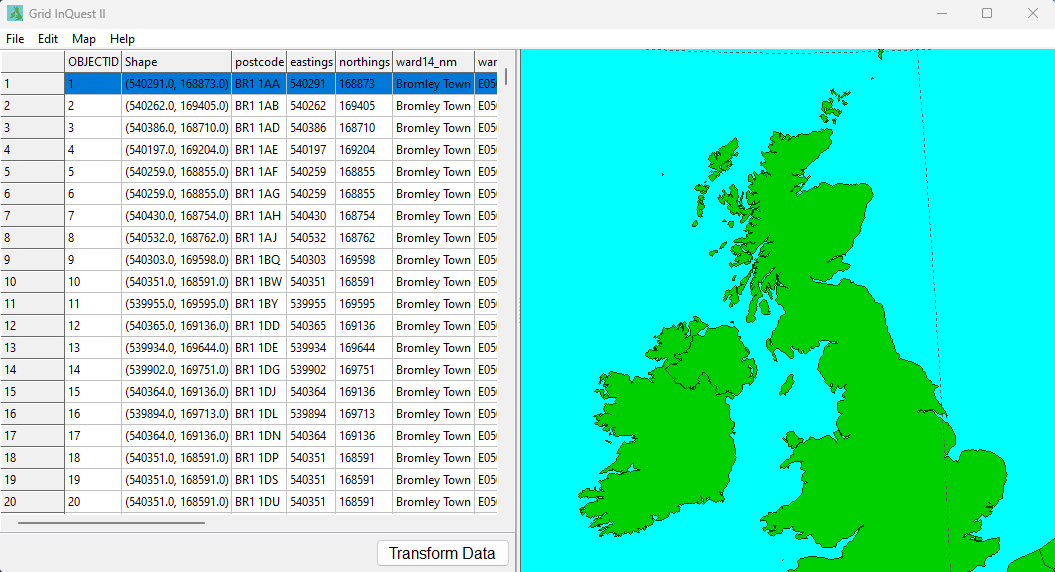

Another drawback with the dataset is that, as of the time of writing, it does not incorporate the most recent administrative codes. For example, it's using a Pan Strategic Health Authorities code `E18000007` to identify London region which according to [Find that Postcode](https://findthatpostcode.uk/areas/E18000007.html) had been terminated in 2013. More critically, the dataset is missing live postcodes. For example, `BR5 4ND` is an active postcode in Bromley but it is absent from the CPO dataset. This raises concerns about the dataset's applicability and accuracy, which may also create difficulties when attempting to link it with other datasets.

In [2]:
# Read in the postcode data from the London Datastore
def read_london_postcode_data(file_name):
    source = f'{file_name}.csv'
    columns = ['postcode', 'ward14_nm', 'ward14_cd', 'boroughcd', 'borough', 'rgn11_nm', 'rgn11_cd', 'ETRS89GD-Lat', 'ETRS89GD-Long']

    df = pd.read_csv(source, header=0, usecols=columns, index_col='postcode')
    df.columns = ['ward', 'ward_code', 'borough_code', 'borough', 'region_code', 'region', 'lat', 'lon']
                  
    df = df.add_prefix('cpo_')
    df.index.name = 'cpo_postcode'
    return df

# postcode_df = read_london_postcode_data('../data/CodePointOpen_London_201709_geodesic')

# Try an interactive mapping here? https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html https://gautis.medium.com/converting-eastings-and-northings-to-latitude-and-longitude-4f91c361ab30

In [3]:
# Read in the postcode data from the Code-Point Open dataset
def read_cpo_postcode_data(folder):
    all_files = glob.glob(os.path.join(folder, '*.csv'))
    columns = ['postcode', 'quality_indicator', 'eastings',	'northings', 'country_code', 'ha_regional_code', 'ha_code', 'county_code', 'district_code', 'ward_code']

    london_borough_df = pd.read_csv(f'{folder}/../london_boroughs.csv', header=0);
    london_ward_df = pd.read_csv(f'{folder}/../london_wards.csv', header=0);

    files = []
    for filename in all_files:
        current_df = pd.read_csv(filename, index_col=None, header=None, names=columns, sep=',')

        # Note that the dataset is using an outdated NHS PAN code of London region
        london_df = current_df[current_df['ha_code'] == 'E18000007']

        if (len(london_df) > 0):
            london_df = pd.merge(current_df, london_borough_df, how='left', left_on='district_code', right_on='DISTRICT_CODE')
            london_df = pd.merge(london_df, london_ward_df, how='left', left_on='ward_code', right_on='WARD_CODE')

            # Clean ups
            london_df.rename(columns={'BOROUGH': 'borough', 'DISTRICT_CODE': 'borough_code', 'WARD': 'ward'}, inplace=True)
            london_df = london_df[['postcode', 'quality_indicator', 'eastings',	'northings', 'borough',	'borough_code',	'ward', 'ward_code']]
            files.append(london_df)

    df = pd.concat(files, axis=0, ignore_index=True)
    df = df.add_prefix('CPO_')
    return df

postcode_df = read_cpo_postcode_data('./data/input/codepo_gb')

In [4]:
postcode_df[postcode_df['CPO_postcode'].str.startswith('BR5 4N')]

,CPO_postcode,CPO_quality_indicator,CPO_eastings,CPO_northings,CPO_borough,CPO_borough_code,CPO_ward,CPO_ward_code
4669,BR5 4NE,10,547571,166012,Bromley,E09000006,Orpington,E05014001
4670,BR5 4NF,10,547722,166090,Bromley,E09000006,Orpington,E05014001
4671,BR5 4NG,10,547443,166180,Bromley,E09000006,Orpington,E05014001
4672,BR5 4NH,10,547696,166184,Bromley,E09000006,Orpington,E05014001
4673,BR5 4NJ,10,547725,166259,Bromley,E09000006,Orpington,E05014001
4674,BR5 4NQ,10,547440,166222,Bromley,E09000006,Orpington,E05014001
4675,BR5 4NY,10,547629,166257,Bromley,E09000006,Orpington,E05014001
4676,BR5 4NZ,10,547618,166300,Bromley,E09000006,Orpington,E05014001


Another option is to source postcode information from [UPRN Directory for London](https://geoportal.statistics.gov.uk/datasets/ons-uprn-directory-february-2023/about) published by Office for National Statistics (ONS), which is also covered by the [Open Government Licence 3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/). The dataset is quite large as it covers the entire United Kingdom, approximately 1.7 million postcodes. It contains information on their associated administrative codes, and notably, the latest version incorporates 2022 census data. The dataset identifier Unique Property Reference Number (UPRN) can be conveniently used to link residential properties, as well as Police Force Area (PFA) code, which may prove valuable for subsequent analysis and modelling. It is updated every 6 weeks and is available in CSV format. The full spec can be found in the zip file under User Guide.

Given that the dataset contains not only postcodes but also all UPRN identifiers in the UK, it is considerably large. The downloaded compressed file is over 12 GB but it is divided into multiple smaller files for easier handling. We can write a function to read and process each file sequentially and consolidate all the cleaned and curated results into a single, merged dataset at the end. This refined data can then be saved as a parquet file for further use. Leveraging this utility function, we are able to extract over 5 million records in just 5 minutes. 

For the purpose of this project, we will use the ONS UPRN Directory dataset as the primary source for linking UPRN with postcode data. We will also take the [Output Area code and Super Output Area code](https://ocsi.uk/2019/03/18/lsoas-leps-and-lookups-a-beginners-guide-to-statistical-geographies/) from the ONS dataset, which could be useful to link some Census data.

Note that it was later found the ONS UPRN Directory dataset may contain some errors. For example, postcode `BR6 7SJ` was mapped to Bromley in the EPC records but according to in the ONS dataset, it belongs to Sevenoaks, and [the actual map](https://findthatpostcode.uk/postcodes/BR6%207SJ.html) does show the postcode lies within Bromley rather than in Sevenoaks.
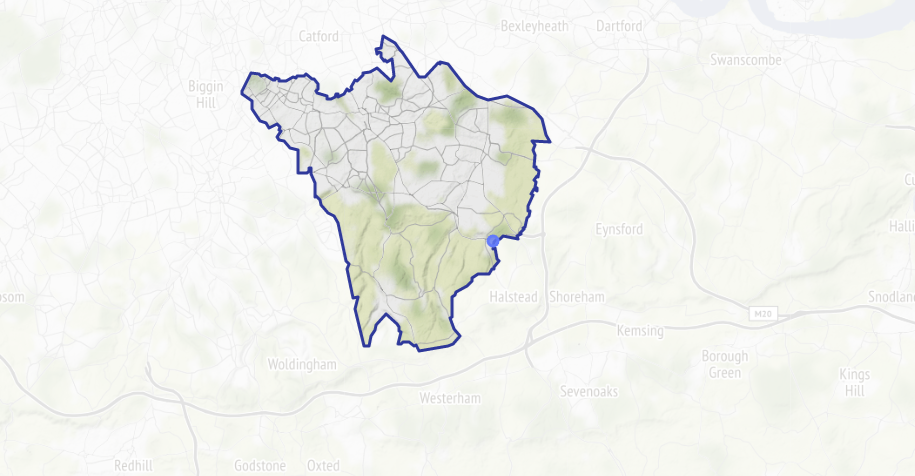

Because the mismatches only account for a small portion of records (a cross validation against the borough lookup revealed only `3066` London properties are missing from the selection, which counts approximately `3066/5,148,355=0.06%`), we will continue to use ONS UPRN Directory as the primary source for filtering large datasets to only London residential properties. Note that number also matches with the official documentation, which states that the dataset contains `5,145,289` London records.

In [5]:
import modules.dataset_onsud as onsud

onsud_df = onsud.load_data(london_only=True)

Loading saved data from ./data/saved/saved_onsud_feb_2023.parquet...


In [6]:
onsud_df[onsud_df['ONSUD_POSTCODE'] == 'BR2 0QA']

,ONSUD_REGION,ONSUD_POSTCODE,ONSUD_BOROUGH,ONSUD_BOROUGH_CODE,ONSUD_WARD,ONSUD_WARD_CODE,ONSUD_OA,ONSUD_MSOA,ONSUD_LSOA
ONSUD_UPRN,,,,,,,,,
10013150654,E12000007,BR2 0QA,Bromley,E09000006,Shortlands & Park Langley,E05014005,E00004073,E02000147,E01000831
10070007582,E12000007,BR2 0QA,Bromley,E09000006,Shortlands & Park Langley,E05014005,E00004073,E02000147,E01000831
10070007583,E12000007,BR2 0QA,Bromley,E09000006,Shortlands & Park Langley,E05014005,E00004073,E02000147,E01000831
10070007584,E12000007,BR2 0QA,Bromley,E09000006,Shortlands & Park Langley,E05014005,E00004073,E02000147,E01000831
10070007585,E12000007,BR2 0QA,Bromley,E09000006,Shortlands & Park Langley,E05014005,E00004073,E02000147,E01000831
...,...,...,...,...,...,...,...,...,...
100022890262,E12000007,BR2 0QA,Bromley,E09000006,Shortlands & Park Langley,E05014005,E00004073,E02000147,E01000831
100022890429,E12000007,BR2 0QA,Bromley,E09000006,Shortlands & Park Langley,E05014005,E00004073,E02000147,E01000831
100023632277,E12000007,BR2 0QA,Bromley,E09000006,Shortlands & Park Langley,E05014005,E00004073,E02000147,E01000831


In [7]:
print(f'Postcode data shape: {onsud_df.shape}')

Postcode data shape: (5145289, 9)


# Load EPC Data

Energy Performance Certificate (EPC) data is available from the Ministry of Housing, Communities & Local Government's [Open Data Communities](https://epc.opendatacommunities.org/) website. It can be used to determine the energy performance and environmental impact of a property, including its energy consumption and CO2 emissions. Moreover, the EPC data provides additional details, such as the property's glazing type and floor size which could become important factors when comes to determine the property's value. The data is organised by local authority and is updated on a monthly basis. Due to it containing third-party product features, more specifically Ordnance Survey's AddressBase Premium product information, the data is published under a copyright and database right information notice, but rest assured, our usage for this project is permitted by the third clause:
> 3. Promotion and better understanding of the current energy efficiency of buildings and potential improvement in the building sale or rental market.

To extract all EPCs for the Greater London area, we first need to obtain a list of the 33 London local authority code, with which we can then filter the relevant records from the EPC extracts. The Ordnance Survey's postcode dataset serves as a reliable resource for generating an accurate list of these authority codes.

In [8]:
boroughs = onsud_df[['ONSUD_BOROUGH', 'ONSUD_BOROUGH_CODE']].drop_duplicates()
boroughs.count()

ONSUD_BOROUGH         33
ONSUD_BOROUGH_CODE    33
dtype: int64

We start by defining a list of boroughs we are interested in so we can focus on a smaller subset of the data. We then read EPC data from the sub folders one by one.

In [9]:
import modules.dataset_epc as epc

epc_df = epc.load_data(boroughs)

Loading saved data from ./data/saved/saved_all_epc_2023.parquet...


In [10]:
len(epc_df)

3750368

In [11]:
epc_df[epc_df['EPC_ADDRESS2'] == '7, Durham Avenue']

,EPC_ADDRESS1,EPC_ADDRESS2,EPC_ADDRESS3,EPC_POSTCODE,EPC_CURRENT_ENERGY_RATING,EPC_PROPERTY_TYPE,EPC_BUILT_FORM,EPC_INSPECTION_DATE,EPC_ENERGY_CONSUMPTION_CURRENT,EPC_CO2_EMISSIONS_CURRENT,EPC_TOTAL_FLOOR_AREA,EPC_FLOOR_LEVEL,EPC_NUMBER_HABITABLE_ROOMS,EPC_WINDOWS_ENERGY_EFF,EPC_WALLS_ENERGY_EFF,EPC_ROOF_ENERGY_EFF,EPC_MAINHEAT_ENERGY_EFF,EPC_LIGHTING_ENERGY_EFF,EPC_FLOOR_HEIGHT,EPC_ADDRESS,EPC_CONSTRUCTION_AGE_BAND,EPC_TENURE,EPC_UPRN
EPC_LMK_KEY,,,,,,,,,,,,,,,,,,,,,,,
709257519262014013011451582118524,Flat 4 Pine Tree Lodge,"7, Durham Avenue",None,BR2 0QA,C,Flat,Mid-Terrace,2014-01-29,135,2.1,80.0,1st,3.0,Average,Good,None,Good,Very Good,NaN,"Flat 4 Pine Tree Lodge, 7, Durham Avenue",England and Wales: 1983-1990,owner-occupied,100020396370.0
266765323612010092817562396200060,Flat 8 Pine Tree Lodge,"7, Durham Avenue",None,BR2 0QA,D,Flat,Semi-Detached,2010-09-27,276,3.9,84.58,Ground,3.0,Average,Good,None,Average,Poor,2.41,"Flat 8 Pine Tree Lodge, 7, Durham Avenue",England and Wales: 1983-1990,owner-occupied,100020396374.0
266765330962009041518203900658301,Flat 8 Pine Tree Lodge,"7, Durham Avenue",None,BR2 0QA,D,Flat,Semi-Detached,2009-04-15,266,3.8,85.9,Ground,3.0,Average,Good,None,Good,Very Poor,2.4,"Flat 8 Pine Tree Lodge, 7, Durham Avenue",England and Wales: 1991-1995,owner-occupied,100020396374.0
711071919022013100116115962098157,Flat 3 Pine Tree Lodge,"7, Durham Avenue",None,BR2 0QA,E,Flat,End-Terrace,2013-10-01,299,5.1,88.0,1st,3.0,Average,Average,None,Good,Good,NaN,"Flat 3 Pine Tree Lodge, 7, Durham Avenue",England and Wales: 1976-1982,owner-occupied,100020396369.0
709805519222016072018000672308336,Flat 10 Pine Tree Lodge,"7, Durham Avenue",None,BR2 0QA,C,Flat,End-Terrace,2016-07-20,175,2.7,87.0,1st,3.0,Average,Good,None,Good,Very Poor,2.43,"Flat 10 Pine Tree Lodge, 7, Durham Avenue",England and Wales: 1983-1990,owner-occupied,100020396376.0
710177449732013112608161743268192,Flat 7 Pine Tree Lodge,"7, Durham Avenue",None,BR2 0QA,C,Flat,Mid-Terrace,2013-11-25,151,2.6,88.0,Ground,3.0,Average,Good,None,Good,Average,NaN,"Flat 7 Pine Tree Lodge, 7, Durham Avenue",England and Wales: 1983-1990,rental (private),100020396373.0
710099181452014100216200693049491,Flat 6 Pine Tree Lodge,"7, Durham Avenue",None,BR2 0QA,C,Flat,Mid-Terrace,2014-10-02,114,1.7,78.0,2nd,3.0,Average,Good,Good,Good,Very Good,NaN,"Flat 6 Pine Tree Lodge, 7, Durham Avenue",England and Wales: 1991-1995,owner-occupied,100020396372.0
708160919262014112515574022158014,Flat 1 Pine Tree Lodge,"7, Durham Avenue",None,BR2 0QA,D,Flat,End-Terrace,2014-11-25,230,3.7,83.0,Ground,3.0,Average,Average,None,Good,Very Poor,NaN,"Flat 1 Pine Tree Lodge, 7, Durham Avenue",England and Wales: 1976-1982,owner-occupied,100020396367.0
100530879832018013020533182768204,"Flat 11, Pine Tree Lodge","7, Durham Avenue",None,BR2 0QA,C,Flat,Mid-Terrace,2018-01-30,141,2.1,83.0,2nd,3.0,Average,Good,Good,Good,Very Poor,NaN,"Flat 11, Pine Tree Lodge, 7, Durham Avenue",England and Wales: 1983-1990,rental (private),100020396377.0


We were able to load around 3.7 million the EPC records for all 33 London authorities in about 3 minutes.

# Process and Enrich EPC Data

We will use ONS UPRN Directory to enrich the EPC data with borough and local authority information.

Also for geographic location information, we can rely on the `UPRN` column. The Unique Property Reference Number (`UPRN`) which is a 12-digit number that is assigned to every addressable location in the UK by the Royal Mail to uniquely identify that property. Ordnance Survey also publishes a dataset called [Open UPRN](https://osdatahub.os.uk/downloads/open/OpenUPRN) that contains the British National Grid location easting, northing and latitude, longitude (`UPRN_X_COORDINATE`, `UPRN_Y_COORDINATE`) for all UPRN in the UK. We can use this dataset to geo-coordinates to the EPC dataset.

There are also some duplicate records with the same UPRN in the EPC dataset. This is because multiple inspections could be logged against the same property over the years. We will remove these duplicates by keeping only the most recent inspection record for each property. Any records that do not have a valid `UPRN` will be removed as well.

We are also be interested to see if any energy performance feature of the property has a significant impact on its value. We will therefore pick three more columns from the EPC dataset, namely `CURRENT_ENERGY_RATING`, `ENERGY_CONSUMPTION_CURRENT` and `CO2_EMISSIONS_CURRENT`.

In [12]:
import modules.dataset_uprn as uprn

# Load the UPRN data
uprn_df = uprn.load_data()

Loading saved data from ./data/saved/osopenuprn_202301.parquet...


In [13]:
len(uprn_df)

40298590

In [14]:
london_uprn_df = onsud_df.merge(uprn_df, how='left', left_index=True, right_index=True)

# Make sure every London ONS URPN has a matching geo-coordinate
london_uprn_no_match = london_uprn_df[london_uprn_df['UPRN_LATITUDE'].isna()]
london_uprn_no_match[['ONSUD_POSTCODE']].value_counts()

Series([], Name: count, dtype: int64)

In [15]:
import modules.utils as utils

print('Unmatched rate:', utils.format_ratio(len(london_uprn_no_match), len(london_uprn_df)))

Unmatched rate: 0.0000%


In [16]:
# Number of EPC records that have the same UPRN
epc_df[epc_df['EPC_UPRN'].notna()]['EPC_UPRN'].value_counts()

EPC_UPRN
100023547753.0    188
10094188374.0     166
6163068.0          85
6163247.0          53
5082592.0          39
                 ... 
100021179622.0      1
100023190749.0      1
100021160645.0      1
100021198153.0      1
100021219329.0      1
Name: count, Length: 2564371, dtype: int64

In [17]:
# For a small number of buildings, multiple EPC records share the same UPRN
epc_df[epc_df['EPC_UPRN'] == 100023547753]

,EPC_ADDRESS1,EPC_ADDRESS2,EPC_ADDRESS3,EPC_POSTCODE,EPC_CURRENT_ENERGY_RATING,EPC_PROPERTY_TYPE,EPC_BUILT_FORM,EPC_INSPECTION_DATE,EPC_ENERGY_CONSUMPTION_CURRENT,EPC_CO2_EMISSIONS_CURRENT,EPC_TOTAL_FLOOR_AREA,EPC_FLOOR_LEVEL,EPC_NUMBER_HABITABLE_ROOMS,EPC_WINDOWS_ENERGY_EFF,EPC_WALLS_ENERGY_EFF,EPC_ROOF_ENERGY_EFF,EPC_MAINHEAT_ENERGY_EFF,EPC_LIGHTING_ENERGY_EFF,EPC_FLOOR_HEIGHT,EPC_ADDRESS,EPC_CONSTRUCTION_AGE_BAND,EPC_TENURE,EPC_UPRN
EPC_LMK_KEY,,,,,,,,,,,,,,,,,,,,,,,
933163177412013051715544095970701,F09,Ivy House,279 Seven Sisters Road,N4 2DE,D,Flat,Enclosed Mid-Terrace,2013-05-17,403,1.4,18.0,1st,1.0,Average,Very Poor,Very Poor,Good,Good,NaN,"F09, Ivy House, 279 Seven Sisters Road",England and Wales: 1900-1929,rental (social),100023547753.0
933310295732013052011040835978701,G27,Ivy House,279 Seven Sisters Road,N4 2DE,C,Flat,Enclosed Mid-Terrace,2013-05-17,181,1.6,47.0,Ground,1.0,Average,Very Poor,None,Good,Very Good,NaN,"G27, Ivy House, 279 Seven Sisters Road",England and Wales: 1900-1929,rental (social),100023547753.0
932778859042013051723160802879238,F23,Ivy House,279 Seven Sisters Road,N4 2DE,D,Flat,Enclosed Mid-Terrace,2013-05-17,455,1.1,13.0,1st,1.0,Average,Very Poor,Very Poor,Good,Average,NaN,"F23, Ivy House, 279 Seven Sisters Road",England and Wales: 1900-1929,rental (social),100023547753.0
933043272062020070707253358378450,F43,Ivy House,279 Seven Sisters Road,N4 2DE,C,Flat,Mid-Terrace,2020-07-03,269,0.7,15.0,1st,1.0,Average,Good,Average,Good,Very Good,NaN,"F43, Ivy House, 279 Seven Sisters Road",England and Wales: 1930-1949,rental (social),100023547753.0
933071852942020070416442807800978,G03,Ivy House,279 Seven Sisters Road,N4 2DE,C,Flat,Mid-Terrace,2020-07-03,269,0.8,16.0,Ground,1.0,Average,Good,None,Good,Very Good,NaN,"G03, Ivy House, 279 Seven Sisters Road",England and Wales: 1930-1949,rental (social),100023547753.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933064947312013051816255795970508,F40,Ivy House,279 Seven Sisters Road,N4 2DE,D,Flat,Enclosed Mid-Terrace,2013-05-17,421,1.3,16.0,1st,1.0,Average,Very Poor,Very Poor,Good,Average,NaN,"F40, Ivy House, 279 Seven Sisters Road",England and Wales: 1900-1929,rental (social),100023547753.0
932689437952020070707400625000008,F53,Ivy House,279 Seven Sisters Road,N4 2DE,C,Flat,Mid-Terrace,2020-07-03,275,0.7,15.0,1st,1.0,Average,Good,Average,Good,Very Good,NaN,"F53, Ivy House, 279 Seven Sisters Road",England and Wales: 1930-1949,rental (social),100023547753.0
933163152142020070513425306800878,F09,Ivy House,279 Seven Sisters Road,N4 2DE,C,Flat,Mid-Terrace,2020-07-03,289,0.7,14.0,1st,1.0,Average,Good,Average,Good,Very Good,NaN,"F09, Ivy House, 279 Seven Sisters Road",England and Wales: 1930-1949,rental (social),100023547753.0


Enrich EPC data with administrative and geo-location data. We are using the original UPRN (instead of one merged with only London URPNs) because we want to enrich as many EPC records as possible

In [18]:
# Missing UPRN example -> uprn_df.loc[10091939902]
epc_enriched_df = epc.enrich_epc_data(epc_df, london_uprn_df)

Number of unique EPC records with no administrative and geo-location data

In [19]:
import modules.utils as utils

print('EPC with no UPRN:', utils.format_ratio(epc_df['EPC_UPRN'].notna().sum(), len(epc_df)))
print('Matching rate:', utils.format_ratio(len(epc_enriched_df), len(epc_df)))

EPC with no UPRN: 95.3194%
Matching rate: 100.0000%


# Load Price Paid Data

The Price Paid Data represents the most critical component of an Automated Valuation Model. It is the primary source of information on property prices and ultimately serving as the goal for the final model. The dataset is available from the [Land Registry](https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads) website. It contains information on all residential properties sold in England and Wales since 1995. The data is updated on a monthly basis and is available in CSV format. The full spec can be found on the HM Land Registry Price Paid Data [Guidance page](https://www.gov.uk/guidance/about-the-price-paid-data) under the "Explanations of column headers" section.

We can build a function that downloads the latest dataset and extracts the relevant records for the Greater London area. The function will also perform some basic data cleaning and processing, such as removing duplicate records and converting the date column to a datetime object.

In [20]:
import modules.dataset_ppd as ppd

# Uncomment to download the data from the Land Registry website
# all_ppd_df = pd.concat([
#     ppd.load_data(2018, use_saved=False),
#     ppd.load_data(2019, use_saved=False),
#     ppd.load_data(2020, use_saved=False),
#     ppd.load_data(2021, use_saved=False)
# ])

# csv_file = os.path.join('./data/input', 'saved_all_ppd.csv')
# all_ppd_df.to_csv(csv_file)

london_ppd_df = ppd.load_data(london_only=True)

Loading saved data from ./data/saved/saved_all_ppd.parquet...


In [21]:
london_ppd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 453039 entries, {7C2D0701-0D22-4963-E053-6B04A8C07B97} to {D707E536-8799-0AD9-E053-6B04A8C067CC}
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   PPD_Price         453039 non-null  int64         
 1   PPD_TransferDate  453039 non-null  datetime64[ns]
 2   PPD_Postcode      450619 non-null  object        
 3   PPD_PropertyType  453039 non-null  object        
 4   PPD_OldNew        453039 non-null  bool          
 5   PPD_Duration      453039 non-null  object        
 6   PPD_PAON          453039 non-null  object        
 7   PPD_SAON          171996 non-null  object        
 8   PPD_Street        452948 non-null  object        
 9   PPD_Locality      28722 non-null   object        
 10  PPD_TownCity      453039 non-null  object        
 11  PPD_District      453039 non-null  object        
 12  PPD_County        453039 non-null  object        


In [22]:
london_ppd_df['PPD_PropertyType'].value_counts()

PPD_PropertyType
F    227344
T    114861
S     60499
O     30145
D     20190
Name: count, dtype: int64

Some initial data exploration:

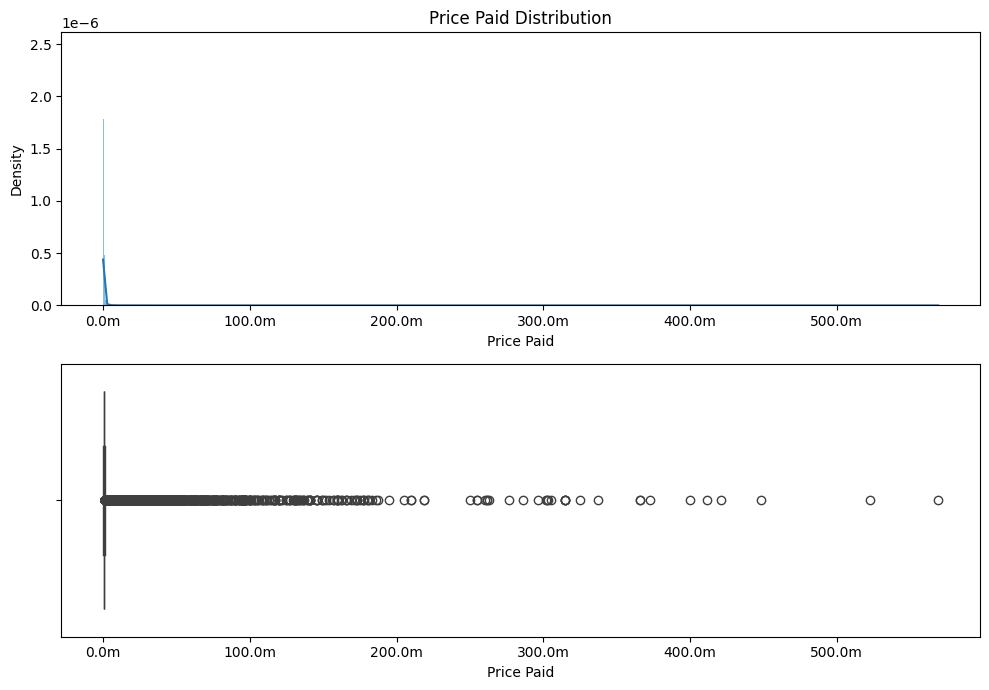

In [23]:
import scipy.stats
import matplotlib.ticker as ticker

# https://www.discoveringstatistics.com/statistics-hell-p/postverta-foundational-statistics/z-scores-and-probability/#:~:text=A%20z%2Dscore%20is%20the,score%20is%20from%20the%20mean.
#
# If the z-score of a data point is more than 3, it is usually considered an
# outlier. This is because, in a normal distribution, about 99.7% of your data
# should lie within ±3 standard deviations from the mean.
# 
# A stricter threshold might consider data points with a z-score of more than 2
# as outliers, since about 95% of the data in a normal distribution lies within
# ±2 standard deviations from the mean.
def remove_outliers(df, col, z=3):
    transformed_col = np.log1p(df[col])
    mask = np.abs(scipy.stats.zscore(transformed_col)) < z
    return df[mask]

chart_df = london_ppd_df.copy()

sns.set_palette("tab10")
fig = plt.figure(figsize=(10, 7))

# Define a custom format function for x-axis ticks
def formatter(x, pos):
    return f'{x * 1e-6}m'

# Histogram plot
ax1 = fig.add_subplot(2, 1, 1)
sns.histplot(data=chart_df, x='PPD_Price', kde=True, stat='density', color=sns.color_palette()[0])
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.title('Price Paid Distribution')
plt.xlabel('Price Paid')

# Boxplot
ax2 = fig.add_subplot(2, 1, 2)
sns.boxplot(x=chart_df['PPD_Price'])
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.xlabel('Price Paid')

plt.tight_layout()
plt.show()

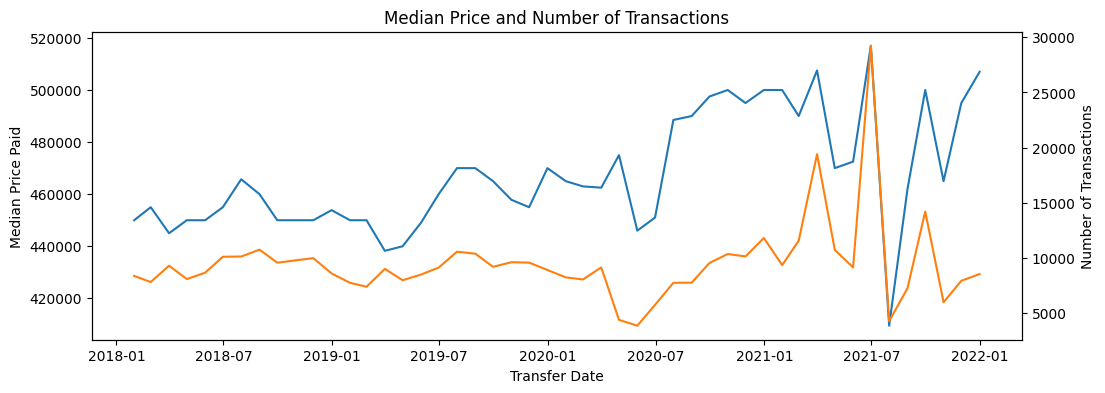

In [24]:
sns.set_palette("tab10")

monthly_median_price = chart_df.resample('M', on='PPD_TransferDate')['PPD_Price'].median().reset_index()
monthly_transactions = chart_df.resample('M', on='PPD_TransferDate').size().reset_index(name='Transactions')

# Plot the smooth line for median price
plt.figure(figsize=(12, 4))
ax1 = sns.lineplot(data=monthly_median_price, x='PPD_TransferDate', y='PPD_Price', color=sns.color_palette()[0])
plt.xlabel('Transfer Date')
plt.ylabel('Median Price Paid')
plt.title('Median Price and Number of Transactions')

ax2 = plt.gca().twinx()

# Plot the number of transactions on the secondary y-axis
sns.lineplot(data=monthly_transactions, x='PPD_TransferDate', y='Transactions', ax=ax2, color=sns.color_palette()[1])
ax2.set_ylabel('Number of Transactions')

plt.show()

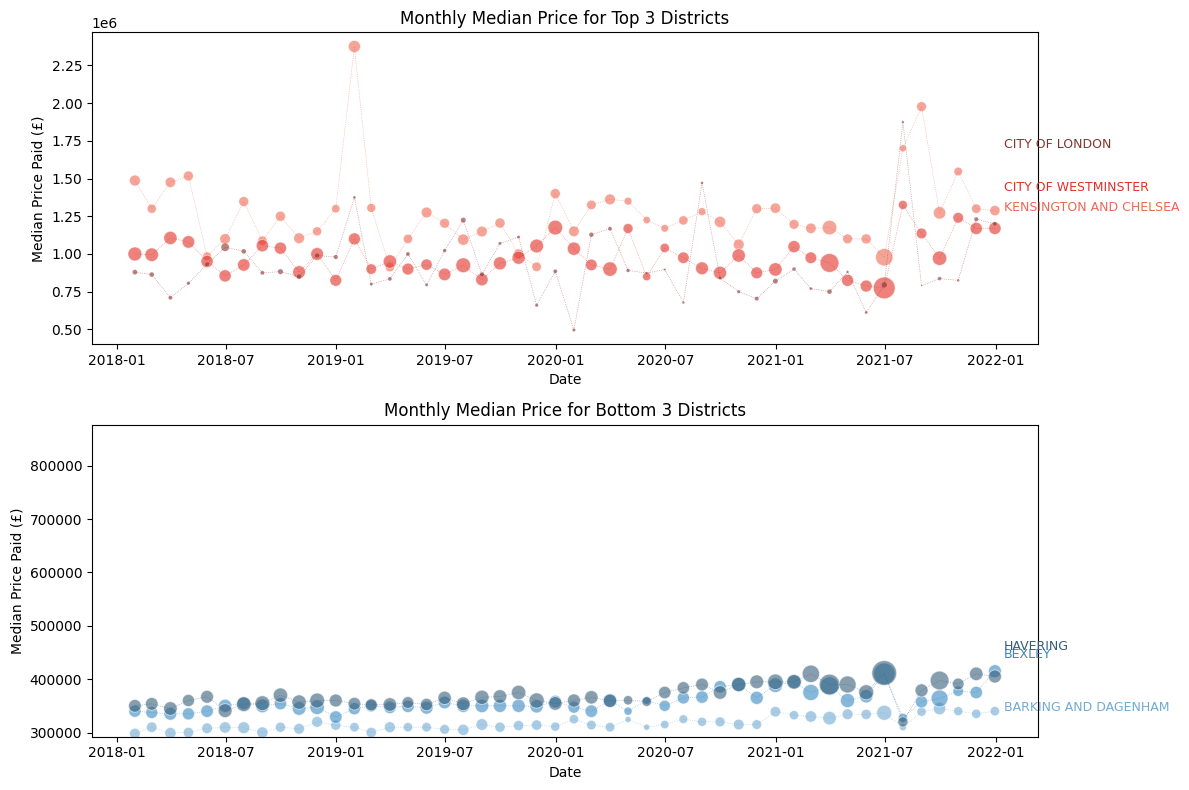

In [25]:
def plot_districts(ax, df, districts, title, color_palette, size_norm=None, offset=0):
    for idx, district in enumerate(districts):
        district_monthly_data = df[df['PPD_District'] == district]
        plot_color = color_palette[idx]
        sns.lineplot(data=district_monthly_data, ax=ax, x='PPD_TransferDate', y='Median_Price', color=plot_color, linestyle=':', linewidth=0.5, alpha=0.6,)
        sns.scatterplot(data=district_monthly_data, ax=ax, x='PPD_TransferDate', y='Median_Price', size='Transactions', sizes=(1, 500), alpha=0.6, color=plot_color, legend=False, size_norm=size_norm)
        annotation_position = (district_monthly_data['PPD_TransferDate'].iloc[-1] + pd.Timedelta(days=15), district_monthly_data['Median_Price'].iloc[-1] + offset * idx)
        ax.annotate(district, annotation_position, fontsize=9, color=plot_color)

    ax.set_xlabel('Date')
    ax.set_ylabel('Median Price Paid (£)')
    ax.set_title(title)
    
# Group the data by district and calculate the monthly median price and number of transactions for each district
district_df = chart_df.reset_index().groupby(['PPD_District', pd.Grouper(key='PPD_TransferDate', freq='M')]).agg(Median_Price=('PPD_Price', 'median'), Transactions=('PPD_Price', 'size')).reset_index()

# Calculate the size normalization based on the overall range of transactions
size_norm = plt.Normalize(district_df['Transactions'].min(), district_df['Transactions'].max())

top_districts = district_df.groupby('PPD_District')['Median_Price'].median().nlargest(3).index
bottom_districts = district_df.groupby('PPD_District')['Median_Price'].median().nsmallest(3).index

fig = plt.figure(figsize=(12, 8))

top_colors = sns.color_palette("Reds_d", n_colors=3)
bottom_colors = sns.color_palette("Blues_d", n_colors=3)

# Plot the data for the top 3 districts
ax1 = fig.add_subplot(2, 1, 1)
plot_districts(ax1, district_df, top_districts, 'Monthly Median Price for Top 3 Districts', top_colors, size_norm, 250000)

# Plot the data for the bottom 3 districts
ax2 = fig.add_subplot(2, 1, 2)
plot_districts(ax2, district_df, bottom_districts, 'Monthly Median Price for Bottom 3 Districts', bottom_colors, size_norm, 25000)

# Get the y-axis range for the bottom 3 districts
y_min_bottom, y_max_bottom = ax2.get_ylim()
ax2.set_ylim(y_min_bottom, y_min_bottom * 3)

plt.tight_layout()
plt.show()

In [26]:
# ppd_selected_df = london_ppd_df[london_ppd_df['PPD_District'] == 'BROMLEY']
london_ppd_df[london_ppd_df['PPD_PropertyType'] == 'O']

,PPD_Price,PPD_TransferDate,PPD_Postcode,PPD_PropertyType,PPD_OldNew,PPD_Duration,PPD_PAON,PPD_SAON,PPD_Street,PPD_Locality,PPD_TownCity,PPD_District,PPD_County,PPD_Category,PPD_RecordStatus
PPD_ID,,,,,,,,,,,,,,,
{7C2D0701-1807-4963-E053-6B04A8C07B97},930000,2018-05-17,HA0 1NR,O,False,F,UNIT 26,None,ABBEY INDUSTRIAL ESTATE,None,WEMBLEY,BRENT,GREATER LONDON,B,A
{7C2D0701-180A-4963-E053-6B04A8C07B97},1050000,2018-09-14,HA2 0EN,O,False,F,202A,None,NORTHOLT ROAD,None,HARROW,HARROW,GREATER LONDON,B,A
{7C2D0701-1810-4963-E053-6B04A8C07B97},1600000,2018-10-22,EN2 8PT,O,False,F,1,None,CHASEWOOD AVENUE,None,ENFIELD,ENFIELD,GREATER LONDON,B,A
{7C2D0701-1812-4963-E053-6B04A8C07B97},49716000,2018-10-24,NW9 6JX,O,False,F,CROWN HONDA,None,HYDE ESTATE ROAD,None,LONDON,BARNET,GREATER LONDON,B,A
{7C2D0701-1819-4963-E053-6B04A8C07B97},3000000,2018-11-15,NW2 7AX,O,False,F,713A,None,NORTH CIRCULAR ROAD,None,LONDON,BRENT,GREATER LONDON,B,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
{D707E536-8780-0AD9-E053-6B04A8C067CC},750000,2021-10-29,NW10 5PA,O,False,F,801,None,HARROW ROAD,None,LONDON,BRENT,GREATER LONDON,B,A
{D707E536-8785-0AD9-E053-6B04A8C067CC},530000,2021-07-28,UB3 4DY,O,False,F,14,None,STATION ROAD,None,HAYES,HILLINGDON,GREATER LONDON,B,A
{D707E536-8789-0AD9-E053-6B04A8C067CC},6187500,2021-09-08,W2 3HB,O,False,F,79 - 81,None,GLOUCESTER TERRACE,None,LONDON,CITY OF WESTMINSTER,GREATER LONDON,B,A


Unfortunately, as the time of writing, the price paid dataset does not include UPRN information. This means that we will need to use available postal information to link the price paid data with the EPC records. However, as mentioned earlier, the postcode data is not granular enough to be used as a primary attribute to link with other datasets as each postcode can cover an average of about 15 properties. This means that although we can use the postcode to select our matches initially, we have to use the address information to further narrow down the EPC of a property and it's sold price. We will need to build a function to clean and standardise the address information in both datasets and then use the standardised address to link the price paid data with the EPC data. 

In [27]:
epc_enriched_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3750368 entries, 1487525379842016101211455442769828 to ff79d6195ab328b13e8222442ad760bbe689f84d4a101251c3180bd2b24d8bbf
Data columns (total 31 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   EPC_ADDRESS1                    object        
 1   EPC_ADDRESS2                    object        
 2   EPC_ADDRESS3                    object        
 3   EPC_POSTCODE                    object        
 4   EPC_CURRENT_ENERGY_RATING       object        
 5   EPC_PROPERTY_TYPE               object        
 6   EPC_BUILT_FORM                  object        
 7   EPC_INSPECTION_DATE             datetime64[ns]
 8   EPC_ENERGY_CONSUMPTION_CURRENT  int64         
 9   EPC_CO2_EMISSIONS_CURRENT       float64       
 10  EPC_TOTAL_FLOOR_AREA            float64       
 11  EPC_FLOOR_LEVEL                 object        
 12  EPC_NUMBER_HABITABLE_ROOMS      float64       
 13  EPC_WINDOWS_ENERG

In [28]:
london_ppd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 453039 entries, {7C2D0701-0D22-4963-E053-6B04A8C07B97} to {D707E536-8799-0AD9-E053-6B04A8C067CC}
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   PPD_Price         453039 non-null  int64         
 1   PPD_TransferDate  453039 non-null  datetime64[ns]
 2   PPD_Postcode      450619 non-null  object        
 3   PPD_PropertyType  453039 non-null  object        
 4   PPD_OldNew        453039 non-null  bool          
 5   PPD_Duration      453039 non-null  object        
 6   PPD_PAON          453039 non-null  object        
 7   PPD_SAON          171996 non-null  object        
 8   PPD_Street        452948 non-null  object        
 9   PPD_Locality      28722 non-null   object        
 10  PPD_TownCity      453039 non-null  object        
 11  PPD_District      453039 non-null  object        
 12  PPD_County        453039 non-null  object        


We will use a Python library called `recordlinkage` to examine the address similarities between the Price Paid Data (PPD) and Energy Performance Certificate (EPC) datasets. The library provides a number of indexing and comparison methods that can be used to match records from sets. With these similarities in mind, we can then use the address information to link the price paid data with the EPC data.

In [29]:
import re

def str_concat(*args):
    replacements = [
        (r'\b(Flat|Apartment|Unit)\s+([A-Za-z0-9]+)\s+(\d+)', r'\1 \2, \3'),  # replace "Flat/Apartment/Unit number number" with "Flat/Apartment/Unit number, number"
        (r'manhattan loft (gardens|apartments)', 'manhattan loft')  # replace "manhattan loft gardens/apartments" with "manhattan loft"
    ]
    
    def replace_patterns(s):
        for pattern, replacement in replacements:
            s = re.sub(pattern, replacement, s, flags=re.IGNORECASE)
        return s

    return ', '.join(replace_patterns(x.lower().replace('\'', '').replace('.', '').replace('the ', '').strip())
                      for x in args if pd.notna(x))

def extract_door_number(address):
    flat_pattern = re.compile(r'\b(Flat|Apartment|Unit)\s+([A-Za-z0-9]+)', re.IGNORECASE)
    flat_match = flat_pattern.search(address)
    return flat_match.group(2) if flat_match else None

def extract_door_name(address):
    number_pattern = re.compile(r'(\b(Flat|Apartment|Unit)\s+\d+,?\s+)(\w.+)', re.IGNORECASE)
    number_match = number_pattern.search(address)
    return number_match.group(3) if number_match else None

def extract_number(address):
    number_pattern = re.compile(r'^(\d+\w*)', re.IGNORECASE)
    number_match = number_pattern.search(address)
    return number_match.group(1) if number_match else None

def extract_name(address):
    name_pattern = re.compile(r'(\d+\w*,?\s+)?([A-Za-z].+)?')
    name_match = name_pattern.search(address)
    return name_match.group(2) if name_match else None

def standardise_address(addr1, addr2, addr3):
    # Standardise address lines
    merged = str_concat(addr1, addr2, addr3).split(', ')
    first, rest = merged[0], merged[1:]

    # Extract the flat/apartment number and name from the first line
    secondary_num = extract_door_number(first)
    secondary_addr = extract_door_name(first) 

    # If there is no flat/apartment information, extract the number and name from the first line
    if secondary_num is None and secondary_addr is None:
        secondary_num = extract_number(first)
        secondary_addr = extract_name(first)

    # Carry out the same process for the rest address lines
    lines = np.array(list(zip(map(extract_number, rest), map(extract_name, rest)))).ravel()  

    return str_concat(secondary_num, secondary_addr, *lines)

In [30]:
# PPD addresses
print(standardise_address(None, 'FLAT 2, 25', 'SAMOS ROAD'))
print(standardise_address('FLAT 7', 'COURTLANDS, 17', 'COURT DOWNS ROAD'))
print(standardise_address('FLAT 10', 'KRUEGER HOUSE, 102', 'MARTINS ROAD'))
print(standardise_address('FLAT F', '7', 'OAKLANDS ROAD'))
print(standardise_address('APARTMENT 27', 'DEWEY COURT, 7', "ST MARK'S SQUARE"))
print(standardise_address('51 - 53', 'GROUND FLOOR SHOP', "ANERLEY ROAD"))
print(standardise_address('FLAT 11', 'SABRA MANSIONS, 155 - 161', 'BATTERSEA RISE'))
print(standardise_address('APARTMENT A61', 'LEGACY BUILDING, 1', 'VIADUCT GARDENS'))
print(standardise_address('APARTMENT 0905', 'MANHATTAN LOFT GARDENS, 22', 'INTERNATIONAL WAY'))
print(standardise_address('APARTMENT 1308', '10', 'MARSH WALL'), end='\n\n')

2, 25, samos road
7, courtlands, 17, court downs road
10, krueger house, 102, martins road
f, 7, oaklands road
27, dewey court, 7, st marks square
51, ground floor shop, anerley road
11, sabra mansions, 155, battersea rise
a61, legacy building, 1, viaduct gardens
0905, manhattan loft, 22, international way
1308, 10, marsh wall



In [31]:
# EPC addresses
print(standardise_address('FLAT 2', 'ALLINGHAM COURT', '26 DURHAM AVENUE'))
print(standardise_address('Flat 8 Allingham Court', '26, Durham Avenue', None))
print(standardise_address('14 Kathleen Moore Court', 'Woodland Way', None))
print(standardise_address('27A BOURDON ROAD', None, None))
print(standardise_address('Flat 42', "Shepheard's House", 'Manor Park Road'))
print(standardise_address('Flat 23 Shepheards House', 'Manor Park Road', None))	
print(standardise_address('Apartment 27 Dewey Court', '7, St. Marks Square', None))	
print(standardise_address('7f Oaklands Road', None, None))
print(standardise_address('Flat F', '51-53, Anerley Road', None))
print(standardise_address('25, St. Davids Close', None, None))
print(standardise_address('A61', 'Legacy Building', '1 Viaduct Gardens'))
print(standardise_address('Apartment 0905', 'Manhattan Loft Apartments', '22 International Way'))
print(standardise_address('Flat A 11, Lilford Road', 'London', None))
print(standardise_address('Apartment 1308 10 Marsh Wall', None, None), end='\n\n')	

2, allingham court, 26, durham avenue
8, allingham court, 26, durham avenue
14, kathleen moore court, woodland way
27a, bourdon road
42, shepheards house, manor park road
23, shepheards house, manor park road
27, dewey court, 7, st marks square
7f, oaklands road
f, 51, anerley road
25, st davids close
a61, legacy building, 1, viaduct gardens
0905, manhattan loft, 22, international way
a, 11, lilford road, london
1308, 10, marsh wall



In [32]:
epc_enriched_df['EPC_POSTCODE'].isna().sum()

0

Rules limitations:
* It won't be able to match any records that includes the house name in PPD but not in EPC data. For example, `10, krueger house, 102, martins road` won't match `10, 102, martins road`.
* It won't match any record that has a different flat number in PPD and EPC data. For example, `flat 1, 59, venner road` won't match `flat a, 59, venner road`.
* It won't match any record that has a different flat number format in PPD and EPC data. For example, `f, 7, oaklands road` won't match `7f, oaklands road`.

In [33]:
import recordlinkage
from recordlinkage.base import BaseCompareFeature
import modules.utils as utils

class ComparePropertyType(BaseCompareFeature):
    def _compute_vectorized(self, ppd_type, epc_type):
        flat = ppd_type.isin(['F', 'O']) & epc_type.isin(['Flat', 'Maisonette'])
        house = ppd_type.isin(['D', 'S', 'T', 'O']) & epc_type.isin(['House', 'Bungalow', 'Park home', 'Maisonette'])
        return flat | house    


def preprocess_df(df, prefix, property_type, postcode_col, saon_col, paon_col, street_col):
    df = df.copy()
    df[f'{prefix}_Merged'] = df.apply(lambda x: standardise_address(x[saon_col], x[paon_col], x[street_col]), axis=1)
    split = df[f'{prefix}_Merged'].str.split(', ', expand=True)
    df[f'{prefix}_SAON_New'], df[f'{prefix}_PAON_1'], df[f'{prefix}_PAON_2'] = split[0], split[1], split[2]
    return df[[property_type, postcode_col, f'{prefix}_Merged', f'{prefix}_SAON_New', f'{prefix}_PAON_1', f'{prefix}_PAON_2']]

def match_ppd_to_epc(ppd_df, epc_df):
    indexer = recordlinkage.Index()

    # Block on postcode
    indexer.block(left_on='PPD_Postcode', right_on='EPC_POSTCODE')    
    candidates = indexer.index(ppd_df, epc_df)
    print('Total number of candidates', len(candidates))

    # Compare on address
    comparer = recordlinkage.Compare()
    comparer.add(ComparePropertyType('PPD_PropertyType', 'EPC_PROPERTY_TYPE', label='Score_Type'))

    # Loose match on address
    comparer.string(left_on='PPD_Merged', right_on='EPC_Merged', method='jarowinkler', threshold=0.8, label='Score_Address')

    # Exact match on SAON
    comparer.exact('PPD_SAON_New', 'EPC_SAON_New', label='Score_SAON')
    comparer.exact('PPD_PAON_1', 'EPC_PAON_1', label='Score_PAON_1')
    comparer.exact('PPD_PAON_2', 'EPC_PAON_1', label='Score_PAON_2')

    features = comparer.compute(candidates, ppd_df, epc_df).reset_index().merge(ppd_df[['PPD_Merged']], left_on='PPD_ID', right_index=True).merge(epc_df[['EPC_Merged']], left_on='EPC_LMK_KEY', right_index=True)

    features['Score'] = features.loc[:, 'Score_Type':'Score_PAON_2'].sum(axis=1)

    return features.query('Score >= 2')

borough_map = {'CITY OF WESTMINSTER': 'WESTMINSTER'}
features = pd.DataFrame()
with utils.Timer() as t:
    # Preprocess dataframes
    boroughs = np.sort(london_ppd_df['PPD_District'].unique()).tolist()

    for borough in boroughs:
        t.log(f'Started processing borough {borough}')

        ppd_condition = london_ppd_df['PPD_District'] == borough
        current_ppd_df = preprocess_df(london_ppd_df[ppd_condition], 'PPD', 'PPD_PropertyType', 'PPD_Postcode', 'PPD_SAON', 'PPD_PAON', 'PPD_Street')
        
        epc_condition = epc_enriched_df['EPC_POSTCODE'].isin(london_ppd_df[ppd_condition]['PPD_Postcode'].unique())
        current_epc_df = preprocess_df(epc_enriched_df[epc_condition], 'EPC', 'EPC_PROPERTY_TYPE', 'EPC_POSTCODE', 'EPC_ADDRESS1', 'EPC_ADDRESS2', 'EPC_ADDRESS3')
        
        matches = match_ppd_to_epc(current_ppd_df, current_epc_df)

        features = pd.concat([features, matches], ignore_index=True)
        t.log(f'Finished processing borough {borough}')   
    t.log(f'Finished processing all boroughs')

=== Started processing borough BARKING AND DAGENHAM (0.0264s) ===
Total number of candidates 340145
=== Finished processing borough BARKING AND DAGENHAM (6.0356s) ===
=== Started processing borough BARNET (6.0357s) ===
Total number of candidates 676603
=== Finished processing borough BARNET (14.6451s) ===
=== Started processing borough BEXLEY (14.6452s) ===
Total number of candidates 439988
=== Finished processing borough BEXLEY (19.6682s) ===
=== Started processing borough BRENT (19.6683s) ===
Total number of candidates 408444
=== Finished processing borough BRENT (25.4019s) ===
=== Started processing borough BROMLEY (25.4021s) ===
Total number of candidates 655469
=== Finished processing borough BROMLEY (38.2022s) ===
=== Started processing borough CAMDEN (38.2023s) ===
Total number of candidates 449806
=== Finished processing borough CAMDEN (44.4723s) ===
=== Started processing borough CITY OF LONDON (44.4724s) ===
Total number of candidates 61106
=== Finished processing borough CIT

In [34]:
print(len(features))
print(features['PPD_ID'].value_counts(), end='\n\n')

unmatched_df = london_ppd_df[~london_ppd_df.index.isin(features['PPD_ID'])]
print(unmatched_df['PPD_Postcode'].value_counts(), end='\n\n')

16369158
PPD_ID
{CFC9085D-4C99-9A70-E053-6B04A8C09D6A}    818
{CFC9085D-4CBE-9A70-E053-6B04A8C09D6A}    818
{CFC9085D-4CB8-9A70-E053-6B04A8C09D6A}    818
{CFC9085D-4CB7-9A70-E053-6B04A8C09D6A}    818
{CFC9085D-4CB6-9A70-E053-6B04A8C09D6A}    818
                                         ... 
{A96E4ACC-59C8-9205-E053-6C04A8C0DA09}      1
{A96E4ACC-5E20-9205-E053-6C04A8C0DA09}      1
{BA558B33-865D-76EF-E053-6B04A8C0B4B7}      1
{68FEB20B-1330-38DA-E053-6C04A8C051AE}      1
{AE4D86D3-C0B0-4619-E053-6C04A8C03CD0}      1
Name: count, Length: 441958, dtype: int64

PPD_Postcode
HA9 6DE     158
EC2A 2FJ    154
SE17 1PP    104
E14 9SQ      81
SE1 7EN      69
           ... 
W1D 6PR       1
NW10 7AS      1
NW2 7AX       1
W1K 3JP       1
W1K 5JD       1
Name: count, Length: 4197, dtype: int64



In [35]:
from modules.utils import save_data

# Save a backup of the original data
save_data(features, '1_ppd_epc_features')

Saving data to ./data/saved/1_ppd_epc_features.parquet...


In [36]:
features['Score'].value_counts()

Score
3.0    12558508
2.0     3282844
4.0      527805
5.0           1
Name: count, dtype: int64

EPC seems to miss some postcodes. For example, `BR1 2GP` is a valid postcode and it is in the PPD data but it is missing from EPC data.

In [37]:
london_ppd_df[london_ppd_df['PPD_Postcode'] == 'BR1 2GP']

,PPD_Price,PPD_TransferDate,PPD_Postcode,PPD_PropertyType,PPD_OldNew,PPD_Duration,PPD_PAON,PPD_SAON,PPD_Street,PPD_Locality,PPD_TownCity,PPD_District,PPD_County,PPD_Category,PPD_RecordStatus
PPD_ID,,,,,,,,,,,,,,,
{D22473F5-F1F7-7B40-E053-6C04A8C0A630},360000,2020-11-25,BR1 2GP,F,True,L,"NAPOLEON HOUSE, 55",FLAT 11,LIDDON ROAD,None,BROMLEY,BROMLEY,GREATER LONDON,A,A
{D22473F5-F1FE-7B40-E053-6C04A8C0A630},365000,2020-12-09,BR1 2GP,F,True,L,"NAPOLEON HOUSE, 55",FLAT 4,LIDDON ROAD,None,BROMLEY,BROMLEY,GREATER LONDON,A,A
{D22473F6-9104-7B40-E053-6C04A8C0A630},5000,2020-05-15,BR1 2GP,O,True,L,"NAPOLEON HOUSE, 55",FLAT 3,LIDDON ROAD,None,BROMLEY,BROMLEY,GREATER LONDON,B,A
{DE2D0CE0-1DF6-51EE-E053-6C04A8C00671},315000,2020-12-11,BR1 2GP,F,True,L,"NAPOLEON HOUSE, 55",FLAT 13,LIDDON ROAD,None,BROMLEY,BROMLEY,GREATER LONDON,A,A
{DE2D0CE0-1E3E-51EE-E053-6C04A8C00671},370000,2020-05-15,BR1 2GP,F,True,L,"NAPOLEON HOUSE, 55",FLAT 14,LIDDON ROAD,None,BROMLEY,BROMLEY,GREATER LONDON,A,A
{BEF7EBBF-4161-7A76-E053-6B04A8C092F7},285000,2020-05-15,BR1 2GP,F,True,L,"NAPOLEON HOUSE, 55",FLAT 12,LIDDON ROAD,None,BROMLEY,BROMLEY,GREATER LONDON,A,A
{BEF7EBBF-4165-7A76-E053-6B04A8C092F7},280000,2020-05-20,BR1 2GP,F,True,L,"NAPOLEON HOUSE, 55",FLAT 6,LIDDON ROAD,None,BROMLEY,BROMLEY,GREATER LONDON,A,A
{BEF7EBBF-4168-7A76-E053-6B04A8C092F7},310000,2020-05-15,BR1 2GP,F,True,L,"NAPOLEON HOUSE, 55",FLAT 16,LIDDON ROAD,None,BROMLEY,BROMLEY,GREATER LONDON,A,A
{BEF7EBBF-4182-7A76-E053-6B04A8C092F7},380000,2020-07-08,BR1 2GP,F,True,L,"NAPOLEON HOUSE, 55",FLAT 17,LIDDON ROAD,None,BROMLEY,BROMLEY,GREATER LONDON,A,A


In [38]:
epc_df[epc_df['EPC_POSTCODE'].str.contains('BR1 2GP')]

,EPC_ADDRESS1,EPC_ADDRESS2,EPC_ADDRESS3,EPC_POSTCODE,EPC_CURRENT_ENERGY_RATING,EPC_PROPERTY_TYPE,EPC_BUILT_FORM,EPC_INSPECTION_DATE,EPC_ENERGY_CONSUMPTION_CURRENT,EPC_CO2_EMISSIONS_CURRENT,EPC_TOTAL_FLOOR_AREA,EPC_FLOOR_LEVEL,EPC_NUMBER_HABITABLE_ROOMS,EPC_WINDOWS_ENERGY_EFF,EPC_WALLS_ENERGY_EFF,EPC_ROOF_ENERGY_EFF,EPC_MAINHEAT_ENERGY_EFF,EPC_LIGHTING_ENERGY_EFF,EPC_FLOOR_HEIGHT,EPC_ADDRESS,EPC_CONSTRUCTION_AGE_BAND,EPC_TENURE,EPC_UPRN
EPC_LMK_KEY,,,,,,,,,,,,,,,,,,,,,,,


The number of missing postcodes in EPC is

In [39]:
len(london_ppd_df[~london_ppd_df['PPD_Postcode'].isin(epc_df['EPC_POSTCODE'])])

9442

Also due to the fuzzy address matching strategy, it's possible that one PPD record matches with multiple EPC records. For example, `3, Deerwood, Woodlands Road` matches with `3, Deerwood, Woodlands Road` and `3 Woodlands Road`. In this case, we will pick the EPC record with the most recent inspection date.

In [40]:
features[features['PPD_ID'] == '{A96E4ACC-E99F-9205-E053-6C04A8C0DA09}'].sort_values(by='Score', ascending=False)[[
  'PPD_ID',
  'EPC_LMK_KEY',
  'PPD_Merged',
  'EPC_Merged',
  'Score',
  'Score_Type',
  'Score_Address',
  'Score_SAON',
  'Score_PAON_1',
  'Score_PAON_2'
]]

,PPD_ID,EPC_LMK_KEY,PPD_Merged,EPC_Merged,Score,Score_Type,Score_Address,Score_SAON,Score_PAON_1,Score_PAON_2
2185304,{A96E4ACC-E99F-9205-E053-6C04A8C0DA09},768589177232012033016065420768300,"3, deerwood, woodlands road","3, deerwood, woodlands road",4.0,True,1.0,1,1,0
2185309,{A96E4ACC-E99F-9205-E053-6C04A8C0DA09},768589199042016090921111393660218,"3, deerwood, woodlands road","3, deerwood, woodlands road",4.0,True,1.0,1,1,0
2185326,{A96E4ACC-E99F-9205-E053-6C04A8C0DA09},768589171632016100613500560068300,"3, deerwood, woodlands road","3, deerwood, woodlands road",4.0,True,1.0,1,1,0
2185300,{A96E4ACC-E99F-9205-E053-6C04A8C0DA09},164838050842008101420264759289548,"3, deerwood, woodlands road","1, deerwood, woodlands road",3.0,True,1.0,0,1,0
2185305,{A96E4ACC-E99F-9205-E053-6C04A8C0DA09},599400692212011030222340394090788,"3, deerwood, woodlands road","2, deerwood, woodlands road",3.0,True,1.0,0,1,0
2185313,{A96E4ACC-E99F-9205-E053-6C04A8C0DA09},1437436526352016042616401792260042,"3, deerwood, woodlands road","3, woodlands road",3.0,False,1.0,1,0,1
2185327,{A96E4ACC-E99F-9205-E053-6C04A8C0DA09},cc8e2f92d5594a8b745327d2350f1384cb26f963204c35...,"3, deerwood, woodlands road","3, woodlands road",3.0,False,1.0,1,0,1
2185331,{A96E4ACC-E99F-9205-E053-6C04A8C0DA09},164838059842019100317051856210578,"3, deerwood, woodlands road","1, deerwood, woodlands road",3.0,True,1.0,0,1,0
2185293,{A96E4ACC-E99F-9205-E053-6C04A8C0DA09},1325047929402015052601381831652508,"3, deerwood, woodlands road","deerwood house, woodlands road",2.0,True,0.0,0,0,1


In [41]:
print(london_ppd_df.loc['{A96E4ACC-E99F-9205-E053-6C04A8C0DA09}'][['PPD_SAON', 'PPD_PAON', 'PPD_Street', 'PPD_Postcode']], '\n')

print(epc_df.loc['768589171632016100613500560068300'][['EPC_INSPECTION_DATE', 'EPC_ADDRESS1', 'EPC_ADDRESS2', 'EPC_ADDRESS3', 'EPC_POSTCODE']])
print(epc_df.loc['768589199042016090921111393660218'][['EPC_INSPECTION_DATE', 'EPC_ADDRESS1', 'EPC_ADDRESS2', 'EPC_ADDRESS3', 'EPC_POSTCODE']])

PPD_SAON                FLAT 3
PPD_PAON              DEERWOOD
PPD_Street      WOODLANDS ROAD
PPD_Postcode           BR1 2AD
Name: {A96E4ACC-E99F-9205-E053-6C04A8C0DA09}, dtype: object 

EPC_INSPECTION_DATE    2016-09-09 00:00:00
EPC_ADDRESS1               Flat 3 Deerwood
EPC_ADDRESS2                Woodlands Road
EPC_ADDRESS3                          None
EPC_POSTCODE                       BR1 2AD
Name: 768589171632016100613500560068300, dtype: object
EPC_INSPECTION_DATE    2016-09-09 00:00:00
EPC_ADDRESS1               Flat 3 Deerwood
EPC_ADDRESS2                Woodlands Road
EPC_ADDRESS3                          None
EPC_POSTCODE                       BR1 2AD
Name: 768589199042016090921111393660218, dtype: object


In [42]:
epc_df[epc_df['EPC_ADDRESS1'] == 'Flat 3 Deerwood']

,EPC_ADDRESS1,EPC_ADDRESS2,EPC_ADDRESS3,EPC_POSTCODE,EPC_CURRENT_ENERGY_RATING,EPC_PROPERTY_TYPE,EPC_BUILT_FORM,EPC_INSPECTION_DATE,EPC_ENERGY_CONSUMPTION_CURRENT,EPC_CO2_EMISSIONS_CURRENT,EPC_TOTAL_FLOOR_AREA,EPC_FLOOR_LEVEL,EPC_NUMBER_HABITABLE_ROOMS,EPC_WINDOWS_ENERGY_EFF,EPC_WALLS_ENERGY_EFF,EPC_ROOF_ENERGY_EFF,EPC_MAINHEAT_ENERGY_EFF,EPC_LIGHTING_ENERGY_EFF,EPC_FLOOR_HEIGHT,EPC_ADDRESS,EPC_CONSTRUCTION_AGE_BAND,EPC_TENURE,EPC_UPRN
EPC_LMK_KEY,,,,,,,,,,,,,,,,,,,,,,,
768589177232012033016065420768300,Flat 3 Deerwood,Woodlands Road,None,BR1 2AD,D,Flat,End-Terrace,2012-03-30,251,5.8,122.0,1st,3.0,Very Poor,Very Poor,None,Good,Good,2.56,"Flat 3 Deerwood, Woodlands Road",England and Wales: 1900-1929,rental (private),100022887505.0
768589199042016090921111393660218,Flat 3 Deerwood,Woodlands Road,None,BR1 2AD,D,Flat,Semi-Detached,2016-09-09,297,4.2,80.0,1st,4.0,Very Poor,Very Poor,None,Good,Very Good,2.75,"Flat 3 Deerwood, Woodlands Road",England and Wales: 1900-1929,owner-occupied,100022887505.0
768589171632016100613500560068300,Flat 3 Deerwood,Woodlands Road,None,BR1 2AD,D,Flat,Semi-Detached,2016-09-09,297,4.2,80.0,1st,4.0,Very Poor,Very Poor,None,Good,Very Good,2.75,"Flat 3 Deerwood, Woodlands Road",England and Wales: 1900-1929,owner-occupied,100022887505.0


The alternating match on primary and secondary addressable object name is only to account for situations when PAON and SAON are reversed in EPC records. As the result, for duplicate matches we will only keep the one that matches the PAON as it will be more accurate. We will also drop some low quality and irrelevant columns. For example, both PPD and EPC datasets contain a `County` column, but the postcode in the EPC dataset is not as accurate as the one in the PPD dataset (`Greater London Authority` v.s. `Greater London`), and contains null values. We will use the county column in the PPD dataset. 

In [43]:
def merge_ppd_epc(ppd_df, epc_df, features):
    matched = features[features['Score'] >= 4]
    ppd_epc_df = ppd_df.merge(matched, how='left', left_index=True, right_on='PPD_ID')
    ppd_epc_df = ppd_epc_df.merge(epc_df, how='left', left_on='EPC_LMK_KEY', right_index=True)

    # With multiple matches, keep the one that matches the exact PAON
    ppd_epc_df = ppd_epc_df.sort_values(by=['Score_PAON_1']).drop_duplicates('PPD_ID', keep='last')
    ppd_epc_df.drop(['PPD_Merged', 'EPC_Merged', 'EPC_POSTCODE', 'Score_Type', 'Score_SAON', 'Score_Address', 'Score_PAON_1', 'Score_PAON_2', 'Score'], axis=1, inplace=True)
    
    # Set index to PPD_ID
    ppd_epc_df.set_index('PPD_ID', inplace=True)
    
    return ppd_epc_df

ppd_epc_df = merge_ppd_epc(london_ppd_df, epc_enriched_df, features)
print('Exact matching rate:', utils.format_ratio(ppd_epc_df['EPC_LMK_KEY'].notna().sum(), len(london_ppd_df)), end='\n\n')

Exact matching rate: 86.6318%



In [44]:
len(ppd_epc_df)

453039

In [45]:
not_matched = london_ppd_df[~london_ppd_df.index.isin(ppd_epc_df.index)]
not_matched['PPD_Postcode'].value_counts()

Series([], Name: count, dtype: int64)

In [46]:
epc_enriched_df[epc_enriched_df['EPC_POSTCODE'] == 'SE5 9HY']

,EPC_ADDRESS1,EPC_ADDRESS2,EPC_ADDRESS3,EPC_POSTCODE,EPC_CURRENT_ENERGY_RATING,EPC_PROPERTY_TYPE,EPC_BUILT_FORM,EPC_INSPECTION_DATE,EPC_ENERGY_CONSUMPTION_CURRENT,EPC_CO2_EMISSIONS_CURRENT,EPC_TOTAL_FLOOR_AREA,EPC_FLOOR_LEVEL,EPC_NUMBER_HABITABLE_ROOMS,EPC_WINDOWS_ENERGY_EFF,EPC_WALLS_ENERGY_EFF,EPC_ROOF_ENERGY_EFF,EPC_MAINHEAT_ENERGY_EFF,EPC_LIGHTING_ENERGY_EFF,EPC_FLOOR_HEIGHT,EPC_ADDRESS,EPC_CONSTRUCTION_AGE_BAND,EPC_TENURE,EPC_UPRN,ONSUD_BOROUGH,ONSUD_WARD,ONSUD_OA,ONSUD_MSOA,ONSUD_LSOA,UPRN_LATITUDE,UPRN_LONGITUDE,EPC_FIRST_INSPECTION_DATE
EPC_LMK_KEY,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
480827052922020081417374825178500,9a Lilford Road,None,None,SE5 9HY,C,Maisonette,Mid-Terrace,2020-08-13,167,2.2,75.0,Ground,4.0,Very Poor,Very Poor,None,Good,Very Good,NaN,9a Lilford Road,England and Wales: 1900-1929,owner-occupied,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-04-03
526770889002010081211593776809208,Ground Floor Flat,41 Lilford Road,None,SE5 9HY,D,Flat,Semi-Detached,2010-08-10,369,3.2,52.43,1st,2.0,Very Poor,Very Poor,None,Good,Good,3.15,"Ground Floor Flat, 41 Lilford Road",England and Wales: before 1900,rental (private),100021865767.0,Lambeth,Myatt's Fields,E00016069,E02000626,E01003182,51.4706526,-0.1040345,2010-08-10
415867790222009122415285661378801,19b Lilford Road,None,None,SE5 9HY,D,Flat,Mid-Terrace,2009-12-23,296,4.9,98.0,2nd,3.0,Very Poor,Very Poor,Good,Average,Very Good,3.0,19b Lilford Road,England and Wales: before 1900,rental (private),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-04-03
360340710062009090922022517518371,"5, Lilford Road",None,None,SE5 9HY,E,Flat,Mid-Terrace,2009-09-09,324,7.4,110.0,2nd,5.0,Very Poor,Very Poor,Very Poor,Good,Poor,2.9,"5, Lilford Road",England and Wales: before 1900,rental (private),100023275209.0,Lambeth,Myatt's Fields,E00016069,E02000626,E01003182,51.470724,-0.1067818,2009-09-09
66f0dc15cf6383b55229541be2dc58d443bb2eac14c61f3ee752fda30609276c,GROUND FLOOR FLAT,41 LILFORD ROAD,None,SE5 9HY,D,Flat,Semi-Detached,2021-07-29,241,1.9,45.0,01,3.0,Very Poor,Very Poor,None,Good,Very Good,3.0,"GROUND FLOOR FLAT, 41 LILFORD ROAD",England and Wales: 1900-1929,Owner-occupied,100021865767.0,Lambeth,Myatt's Fields,E00016069,E02000626,E01003182,51.4706526,-0.1040345,2010-08-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aa211d81626cddebb1f9ec72af93734d84f3cd37678e9895400cb27c846597b8,"Flat 1, 15 Lilford Road",London,None,SE5 9HY,C,Maisonette,Mid-Terrace,2022-09-07,168,2.2,75.0,00,3.0,Poor,Very Poor,None,Good,Very Good,2.9,"Flat 1, 15 Lilford Road, London",England and Wales: before 1900,Rented (social),200000471033.0,Lambeth,Myatt's Fields,E00016069,E02000626,E01003182,51.4707177,-0.1063933,2022-09-07
af61ef8f11f7a69569c133c80c6acb598cb4fddf857e5a895ac8dca23d7e3ab3,"15, Lilford Road",London,None,SE5 9HY,C,Maisonette,Mid-Terrace,2022-09-07,166,2.7,91.0,01,3.0,Very Poor,Very Poor,Average,Good,Very Good,2.3,"15, Lilford Road, London",England and Wales: before 1900,Rented (social),100023275196.0,Lambeth,Myatt's Fields,E00016069,E02000626,E01003182,51.4707177,-0.1063933,2010-05-05
c641fd5e5f6b88f8f16fbb56b1232bc0f73239f8796648d54a48fd90f92f9479,"Flat A, 23 Lilford Road",London,None,SE5 9HY,C,Maisonette,Mid-Terrace,2022-09-07,176,2.7,88.0,00,3.0,Very Poor,Very Poor,None,Good,Very Good,2.9,"Flat A, 23 Lilford Road, London",England and Wales: before 1900,Rented (social),100021865735.0,Lambeth,Myatt's Fields,E00016069,E02000626,E01003182,51.4707306,-0.1060759,2015-07-23


In [47]:
london_ppd_df[london_ppd_df['PPD_Postcode'] == 'SE5 9HY']

,PPD_Price,PPD_TransferDate,PPD_Postcode,PPD_PropertyType,PPD_OldNew,PPD_Duration,PPD_PAON,PPD_SAON,PPD_Street,PPD_Locality,PPD_TownCity,PPD_District,PPD_County,PPD_Category,PPD_RecordStatus
PPD_ID,,,,,,,,,,,,,,,
{9DBAD222-4B12-6EB3-E053-6B04A8C0F257},365000,2019-05-23,SE5 9HY,F,False,L,41,LOWER GROUND FLOOR FLAT,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A
{BA558B33-292A-76EF-E053-6B04A8C0B4B7},590000,2020-12-02,SE5 9HY,F,False,L,9,FLAT A,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A
{AC07BBD0-7ACC-0445-E053-6C04A8C01E31},650000,2020-03-25,SE5 9HY,F,False,L,43,FLAT 1,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A
{D93B27B1-6E61-3100-E053-6C04A8C08887},360000,2021-11-22,SE5 9HY,F,False,L,41,SECOND FLOOR FLAT,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A
{D93B27B1-6E62-3100-E053-6C04A8C08887},430000,2021-09-24,SE5 9HY,F,False,L,41,LOWER GROUND FLOOR FLAT,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A
{D707E536-0AC8-0AD9-E053-6B04A8C067CC},712500,2021-09-17,SE5 9HY,F,False,L,21,FLAT B,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A
{CB0035E6-44F9-58AE-E053-6B04A8C091AF},496000,2021-04-30,SE5 9HY,F,False,L,11B,None,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A
{D4D42646-6DF8-27F6-E053-6C04A8C0A572},677450,2021-10-19,SE5 9HY,F,False,L,17,FLAT A,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A


In [48]:
ppd_epc_df[ppd_epc_df['PPD_Postcode'] == 'SE5 9HY']

,PPD_Price,PPD_TransferDate,PPD_Postcode,PPD_PropertyType,PPD_OldNew,PPD_Duration,PPD_PAON,PPD_SAON,PPD_Street,PPD_Locality,PPD_TownCity,PPD_District,PPD_County,PPD_Category,PPD_RecordStatus,EPC_LMK_KEY,EPC_ADDRESS1,EPC_ADDRESS2,EPC_ADDRESS3,EPC_CURRENT_ENERGY_RATING,EPC_PROPERTY_TYPE,EPC_BUILT_FORM,EPC_INSPECTION_DATE,EPC_ENERGY_CONSUMPTION_CURRENT,EPC_CO2_EMISSIONS_CURRENT,EPC_TOTAL_FLOOR_AREA,EPC_FLOOR_LEVEL,EPC_NUMBER_HABITABLE_ROOMS,EPC_WINDOWS_ENERGY_EFF,EPC_WALLS_ENERGY_EFF,EPC_ROOF_ENERGY_EFF,EPC_MAINHEAT_ENERGY_EFF,EPC_LIGHTING_ENERGY_EFF,EPC_FLOOR_HEIGHT,EPC_ADDRESS,EPC_CONSTRUCTION_AGE_BAND,EPC_TENURE,EPC_UPRN,ONSUD_BOROUGH,ONSUD_WARD,ONSUD_OA,ONSUD_MSOA,ONSUD_LSOA,UPRN_LATITUDE,UPRN_LONGITUDE,EPC_FIRST_INSPECTION_DATE
PPD_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
{9DBAD222-4B12-6EB3-E053-6B04A8C0F257},365000,2019-05-23,SE5 9HY,F,False,L,41,LOWER GROUND FLOOR FLAT,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A,1257560209962015011515081331748465,Lower Ground Floor Flat,41 Lilford Road,None,D,Flat,Semi-Detached,2015-01-14,269.0,3.1,66.0,Ground,3.0,Very Poor,Very Poor,None,Good,Good,NaN,"Lower Ground Floor Flat, 41 Lilford Road",England and Wales: before 1900,rental (private),100021865767.0,Lambeth,Myatt's Fields,E00016069,E02000626,E01003182,51.4706526,-0.1040345,2010-08-10
{D93B27B1-6E62-3100-E053-6C04A8C08887},430000,2021-09-24,SE5 9HY,F,False,L,41,LOWER GROUND FLOOR FLAT,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A,1257560209962015011515081331748465,Lower Ground Floor Flat,41 Lilford Road,None,D,Flat,Semi-Detached,2015-01-14,269.0,3.1,66.0,Ground,3.0,Very Poor,Very Poor,None,Good,Good,NaN,"Lower Ground Floor Flat, 41 Lilford Road",England and Wales: before 1900,rental (private),100021865767.0,Lambeth,Myatt's Fields,E00016069,E02000626,E01003182,51.4706526,-0.1040345,2010-08-10
{D707E536-0AC8-0AD9-E053-6B04A8C067CC},712500,2021-09-17,SE5 9HY,F,False,L,21,FLAT B,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A,1113336183412016012119293493260923,Flat B,"21, Lilford Road",None,D,Maisonette,Mid-Terrace,2016-01-20,247.0,5.2,116.0,1st,5.0,Poor,Very Poor,Very Poor,Good,Very Good,NaN,"Flat B, 21, Lilford Road",England and Wales: 1900-1929,owner-occupied,100021865732.0,Lambeth,Myatt's Fields,E00016069,E02000626,E01003182,51.4707317,-0.1061479,2013-02-27
{BA558B33-292A-76EF-E053-6B04A8C0B4B7},590000,2020-12-02,SE5 9HY,F,False,L,9,FLAT A,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
{AC07BBD0-7ACC-0445-E053-6C04A8C01E31},650000,2020-03-25,SE5 9HY,F,False,L,43,FLAT 1,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
{D93B27B1-6E61-3100-E053-6C04A8C08887},360000,2021-11-22,SE5 9HY,F,False,L,41,SECOND FLOOR FLAT,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
{CB0035E6-44F9-58AE-E053-6B04A8C091AF},496000,2021-04-30,SE5 9HY,F,False,L,11B,None,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
{D4D42646-6DF8-27F6-E053-6C04A8C0A572},677450,2021-10-19,SE5 9HY,F,False,L,17,FLAT A,LILFORD ROAD,None,LONDON,LAMBETH,GREATER LONDON,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [49]:
ppd_epc_df[(ppd_epc_df['PPD_Postcode'].notna()) & (ppd_epc_df['PPD_Postcode'].str.startswith('BR2 0Q'))][['PPD_PropertyType', 'PPD_Postcode', 'PPD_SAON', 'PPD_PAON', 'PPD_Street', 'EPC_PROPERTY_TYPE', 'EPC_ADDRESS1', 'EPC_ADDRESS2', 'EPC_ADDRESS3']]

,PPD_PropertyType,PPD_Postcode,PPD_SAON,PPD_PAON,PPD_Street,EPC_PROPERTY_TYPE,EPC_ADDRESS1,EPC_ADDRESS2,EPC_ADDRESS3
PPD_ID,,,,,,,,,
{64342BFE-BF80-422C-E053-6C04A8C0FB8A},S,BR2 0QW,None,48,NEWBURY ROAD,House,48 NEWBURY ROAD,None,None
{6DA0844A-50A1-30F2-E053-6B04A8C05F3B},F,BR2 0QT,FLAT 11,"NORFOLK HOUSE, 86",WESTMORELAND ROAD,Flat,Flat 11 Norfolk House,"86, Westmoreland Road",None
{6DA0844A-4F9A-30F2-E053-6B04A8C05F3B},F,BR2 0QX,FLAT 20,"HERRON COURT, 82",WESTMORELAND ROAD,Flat,Flat 20 Herron Court,"82, Westmoreland Road",None
{7011B109-76AD-8ED6-E053-6B04A8C075C1},S,BR2 0QW,None,20,NEWBURY ROAD,House,"20, Newbury Road",None,None
{773788C3-17F4-2CE4-E053-6C04A8C05E57},F,BR2 0QE,FLAT 12,"WOODLANDS, 29",DURHAM AVENUE,Flat,Flat 12 Woodlands,"29, Durham Avenue",None
...,...,...,...,...,...,...,...,...,...
{C6209F5F-C0CC-295E-E053-6C04A8C0DDCC},T,BR2 0QW,None,6,NEWBURY ROAD,House,"6, Newbury Road",None,None
{75050A85-96E1-9A88-E053-6B04A8C02390},F,BR2 0QU,FLAT 5,"KESWICK COURT, 78",WESTMORELAND ROAD,Flat,Flat 5 Keswick Court,"78, Westmoreland Road",None
{D707E536-908A-0AD9-E053-6B04A8C067CC},F,BR2 0QL,None,8A,WESTMORELAND ROAD,Flat,8a Westmoreland Road,None,None


In [50]:
def standardize_floor_level(value):
    if pd.isna(value) or not isinstance(value, str):
        return value

    mapping = {
        'NODATA!': None, 'NO DATA!': None,
        '00': '0', 'ground floor': '0', 'Ground': '0',
        'Basement': '-1',
        '20+': 'top', '20': 'top', '21st or above': 'top',
        'mid floor': 'mid', 'top floor': 'top'
    }

    stripped = value.strip('stndrdth')
    return mapping.get(value, stripped if stripped.isdigit() else value)

ppd_epc_df['EPC_FLOOR_LEVEL'] = ppd_epc_df['EPC_FLOOR_LEVEL'].apply(standardize_floor_level)

In [51]:
ppd_epc_df['EPC_CONSTRUCTION_AGE_BAND'].value_counts()

EPC_CONSTRUCTION_AGE_BAND
England and Wales: 1930-1949       83496
England and Wales: 1900-1929       75378
NO DATA!                           71233
England and Wales: before 1900     38495
England and Wales: 1950-1966       33894
England and Wales: 1967-1975       20877
England and Wales: 1983-1990       13607
England and Wales: 1996-2002       10713
England and Wales: 1976-1982        9690
England and Wales: 2003-2006        8840
England and Wales: 1991-1995        7084
England and Wales: 2007 onwards     4095
2021                                2287
England and Wales: 2007-2011        1572
2019                                 768
INVALID!                             671
2018                                 468
England and Wales: 2012 onwards      441
2020                                 436
2022                                 302
2017                                 198
2013                                  99
2016                                  79
2023                           

In [52]:
ppd_epc_df[ppd_epc_df['PPD_OldNew']]['EPC_CONSTRUCTION_AGE_BAND'].value_counts()

EPC_CONSTRUCTION_AGE_BAND
NO DATA!                           45185
2021                                1856
2019                                 685
2018                                 443
2020                                 285
2017                                 191
2022                                 128
2013                                  93
England and Wales: 1930-1949          76
2016                                  71
England and Wales: before 1900        64
England and Wales: 2003-2006          63
England and Wales: 2012 onwards       62
INVALID!                              50
England and Wales: 1900-1929          45
England and Wales: 1950-1966          45
England and Wales: 1967-1975          36
England and Wales: 2007-2011          36
1929                                  29
England and Wales: 2007 onwards       28
England and Wales: 1976-1982          20
2010                                  20
2014                                  18
England and Wales: 1996-2002   

Each EPC record contains a `CONSTRUCTION_AGE_BAND` attribute indicating the age of the property. This could be an valuable attribute, however, the value is a string with a rough year range. We will need to convert this to a number and save it to a new numeric column `CONSTRUCTION_AGE`. Because the years are not exact, we will use the start year of the range which would create a larger gap between the new and old properties. This more preferable as it enlarges the age gap. 

Because the age would impact property price when it's sold, we will calculate the age based on the transfer date. For example, for range 1930-1949, we will take the start year of the range 1930, which gives us a building age of `2018-1930=88` years when the house is sold in `2018`. For any missing values, where `EPC_CONSTRUCTION_AGE_BAND` is `null` or `NO DATA!` or `INVALID!`, if the property is listed as new from PPD, it's likely to be a new build and we will use the year of the first inspection as a rough estimation. However if the property is not listed as new from PPD, we won't be able to tell the age of the property based on the EPC data and we will set the value as null.

In [53]:
import re
import modules.address as addr
import modules.utils as utils

def standardise_building_age_band(current_year, band, first_inspection, is_new):
    # Find all years in the string using regex
    years = re.findall(r'\b\d{4}\b', band) if pd.notnull(band) else []

    if (len(years) > 0):
        estimated_year = int(years[0])
    elif (is_new & (first_inspection is not None)):
        estimated_year = first_inspection.year
    else:
        estimated_year = None

    return addr.get_age_band(current_year - estimated_year) if estimated_year is not None else None


def add_standardise_age_band(df):
    df = df.copy()
    df['EPC_CONSTRUCTION_AGE'] = df.apply(lambda x: standardise_building_age_band(x['PPD_TransferDate'].year, x['EPC_CONSTRUCTION_AGE_BAND'], x['EPC_FIRST_INSPECTION_DATE'], x['PPD_OldNew']), axis=1)
    return df

# Build age is based on the sold year
standard_df = add_standardise_age_band(ppd_epc_df)
print('Estimated rate:', utils.format_ratio(len(standard_df[standard_df['EPC_CONSTRUCTION_AGE'].notna()]), len(standard_df)), end='\n\n')

Estimated rate: 81.9954%



In [54]:
standard_df[standard_df['EPC_CONSTRUCTION_AGE'].notna()]['EPC_CONSTRUCTION_AGE'].value_counts().sort_index()

EPC_CONSTRUCTION_AGE
5.0       54574
10.0        667
20.0      15290
30.0      17797
40.0      13608
50.0       9690
60.0      20877
70.0      23171
80.0      10723
90.0      56256
100.0    148818
Name: count, dtype: int64

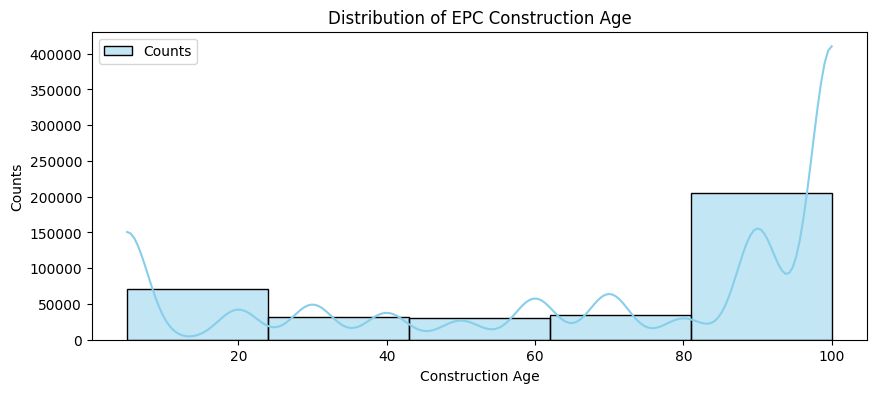

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out NaN values
filtered_ages = standard_df[standard_df['EPC_CONSTRUCTION_AGE'].notna()]['EPC_CONSTRUCTION_AGE']

# Plotting
fig, ax = plt.subplots(figsize=(10, 4))

# Histogram using histplot
sns.histplot(data=filtered_ages, bins=5, kde=True, ax=ax, color='skyblue', label='Counts', stat="count")

ax.set_xlabel('Construction Age')
ax.set_ylabel('Counts')
ax.set_title('Distribution of EPC Construction Age')
ax.legend()

plt.show()

In [56]:
london_ppd_df['PPD_Price'].describe()

count            453039.0
mean      825613.65116469
std     4234352.375168669
min                   1.0
25%              347500.0
50%              475000.0
75%              685000.0
max           569200000.0
Name: PPD_Price, dtype: float64

In [57]:
standard_df['PPD_Price'].describe()

count           453039.0
mean     825613.65116469
std     4234352.37516867
min                  1.0
25%             347500.0
50%             475000.0
75%             685000.0
max          569200000.0
Name: PPD_Price, dtype: float64

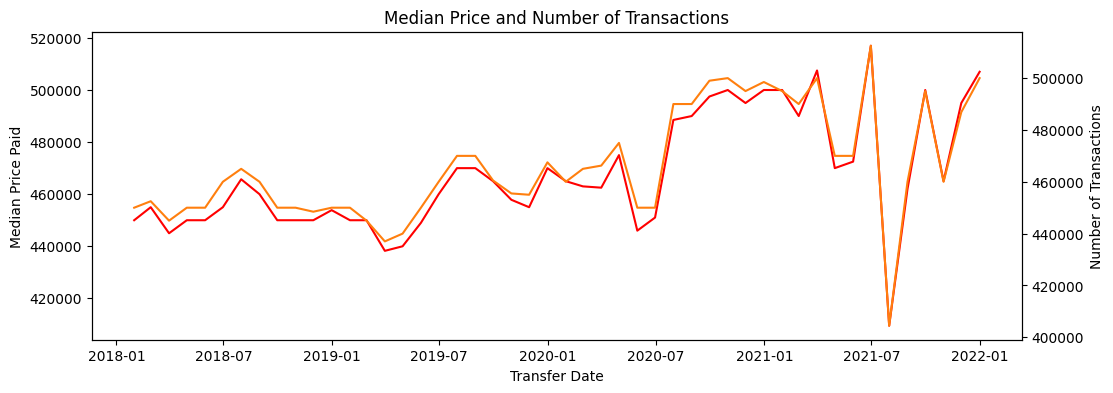

In [62]:
# Set the color palette
sns.set_palette("tab10")

# monthly_median_price = london_ppd_df.resample('M', on='PPD_TransferDate')['PPD_Price'].median().reset_index()
london_chart = london_ppd_df.resample('M', on='PPD_TransferDate')['PPD_Price'].median().reset_index()
standard_chart = standard_df[standard_df['EPC_LMK_KEY'].notna()].resample('M', on='PPD_TransferDate')['PPD_Price'].median().reset_index()

# Plot the smooth line for median price
plt.figure(figsize=(12, 4))
ax1 = sns.lineplot(data=london_chart, x='PPD_TransferDate', y='PPD_Price', color='red')
# sns.lineplot(data=london_chart, x='PPD_TransferDate', y='Transactions', color=sns.color_palette()[0])
plt.xlabel('Transfer Date')
plt.ylabel('Median Price Paid')
plt.title('Median Price and Number of Transactions')

# Create a secondary y-axis
ax2 = plt.gca().twinx()

# Plot the number of transactions on the secondary y-axis
sns.lineplot(data=standard_chart, x='PPD_TransferDate', y='PPD_Price', color=sns.color_palette()[1])
# sns.lineplot(data=standard_chart, x='PPD_TransferDate', y='Transactions', ax=ax2, color=sns.color_palette()[1])
ax2.set_ylabel('Number of Transactions')

plt.show()

<Axes: xlabel='UPRN_LONGITUDE', ylabel='UPRN_LATITUDE'>

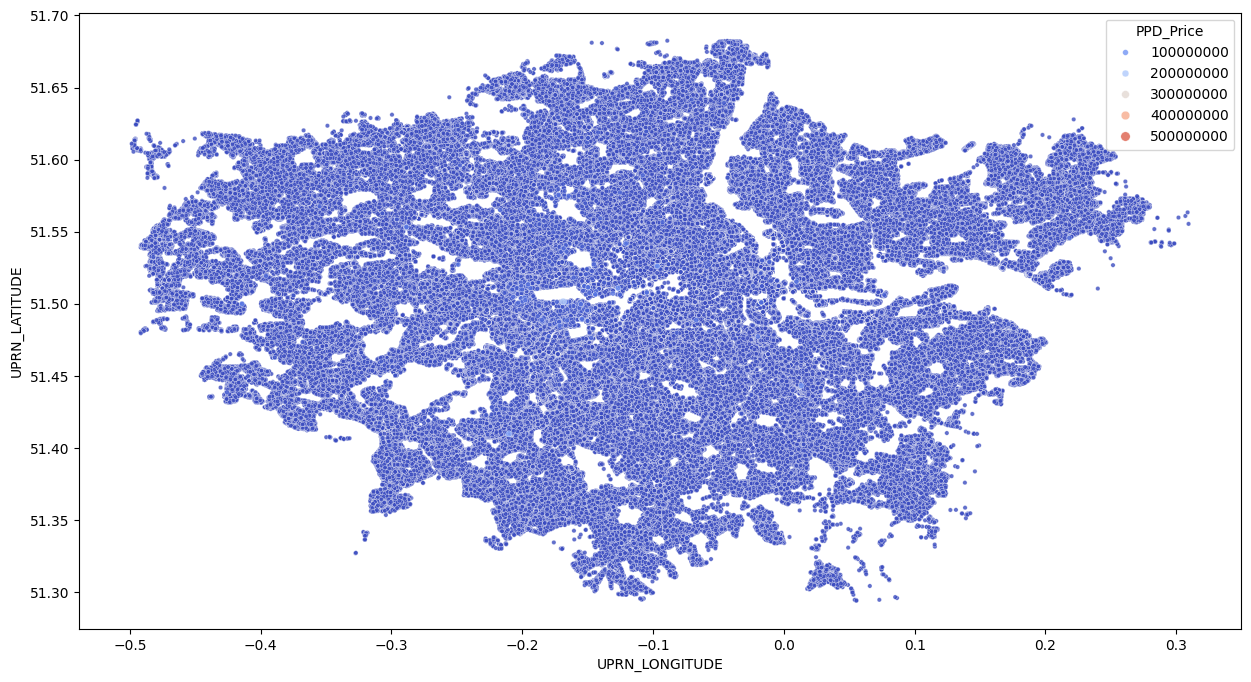

In [59]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x='UPRN_LONGITUDE', y='UPRN_LATITUDE', data=standard_df.sort_values('PPD_Price'), hue='PPD_Price', palette='coolwarm', alpha=0.8, size='PPD_Price', sizes=(10, 50))

In [63]:
from modules.utils import save_data

# Save it for later
save_data(standard_df, '1_ppd_epc_data')

Saving data to ./data/saved/1_ppd_epc_data.parquet...


In [61]:
from modules.utils import load_saved_data

df = load_saved_data('1_ppd_epc_data')
df[df['PPD_Price'] == df[df['PPD_PropertyType'] != 'O']['PPD_Price'].max()]

Loading saved data from ./data/saved/1_ppd_epc_data.parquet...


,PPD_Price,PPD_TransferDate,PPD_Postcode,PPD_PropertyType,PPD_OldNew,PPD_Duration,PPD_PAON,PPD_SAON,PPD_Street,PPD_Locality,PPD_TownCity,PPD_District,PPD_County,PPD_Category,PPD_RecordStatus,EPC_LMK_KEY,EPC_ADDRESS1,EPC_ADDRESS2,EPC_ADDRESS3,EPC_CURRENT_ENERGY_RATING,EPC_PROPERTY_TYPE,EPC_BUILT_FORM,EPC_INSPECTION_DATE,EPC_ENERGY_CONSUMPTION_CURRENT,EPC_CO2_EMISSIONS_CURRENT,EPC_TOTAL_FLOOR_AREA,EPC_FLOOR_LEVEL,EPC_NUMBER_HABITABLE_ROOMS,EPC_WINDOWS_ENERGY_EFF,EPC_WALLS_ENERGY_EFF,EPC_ROOF_ENERGY_EFF,EPC_MAINHEAT_ENERGY_EFF,EPC_LIGHTING_ENERGY_EFF,EPC_FLOOR_HEIGHT,EPC_ADDRESS,EPC_CONSTRUCTION_AGE_BAND,EPC_TENURE,EPC_UPRN,ONSUD_BOROUGH,ONSUD_WARD,ONSUD_OA,ONSUD_MSOA,ONSUD_LSOA,UPRN_LATITUDE,UPRN_LONGITUDE,EPC_FIRST_INSPECTION_DATE,EPC_CONSTRUCTION_AGE
PPD_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
{726BF13B-B4D7-0A46-E053-6C04A8C01D0D},160000000,2018-05-10,SW1X 7LJ,F,False,L,"ONE HYDE PARK, 100",APARTMENT B.10.01,KNIGHTSBRIDGE,None,LONDON,CITY OF WESTMINSTER,GREATER LONDON,B,A,None,None,None,None,None,None,None,NaT,NaN,NaN,NaN,None,NaN,None,None,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaT,NaN
{87E1551E-EAE9-6405-E053-6C04A8C0B2EE},160000000,2019-04-09,SW1X 7LJ,O,False,L,"ONE HYDE PARK, 100",APARTMENT B.10.01,KNIGHTSBRIDGE,None,LONDON,CITY OF WESTMINSTER,GREATER LONDON,B,A,None,None,None,None,None,None,None,NaT,NaN,NaN,NaN,None,NaN,None,None,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None,NaN,NaN,NaT,NaN
